In [1]:
import ee
import geemap
import pandas as pd
from matplotlib import pyplot


#ee.Authenticate()  # Only needed for the first time
ee.Initialize()
Map= geemap.Map()

In [2]:
lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
    .filter(ee.Filter.eq('GNIS_Name', 'Big Moose Lake'))



In [17]:
station = ee.Geometry.Point(-74.85423940003443,43.81880036802749)
#station = ee.Geometry.Point(-74.860826362721,43.82503425692791)

Map.addLayer(station)
Map.centerObject(station, 16)
Map

Map(bottom=6112145.0, center=[43.81880036802749, -74.85423940003443], controls=(WidgetControl(options=['positi…

In [18]:
LC5_BANDS = ['SR_B1',   'SR_B2',    'SR_B3',  'SR_B4',  'SR_B5',    'SR_B7',    'ST_B6','QA_PIXEL']; #Llandsat 5
LC8_BANDS = ['SR_B2','SR_B3','SR_B4',  'SR_B5','SR_B6','SR_B7','ST_B10','QA_PIXEL']; #Landsat 8
STD_NAMES = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'temp','QA'];


In [19]:
def cdom(img):
    cdo = img.expression("(20.3 - 10. * (b2 / b3) - 2.4 * (b3 / b4))", {
        'b1' : img.select('blue'),
        'b2' : img.select('green'),
        'b3' : img.select('red'),
        'b4' : img.select('nir')
    }).rename("CO")
    
    bad2 = cdo.where((cdo.gte(0)),1).rename("bad2");
    co= cdo.multiply(bad2).rename("CO");
    mask = co.neq(0);

    return img.addBands([co]).clip(lake).updateMask(mask)
#     return ee.Image(img
#       .addBands(co)
#       .clip(lake)
#       .updateMask(mask)
#     )   
#         #return img.addBands([co])


In [20]:
def maskL457sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    qa = image.select('QA_PIXEL')
    cloud = qa.bitwiseAnd(1 << 5).Or(qa.bitwiseAnd(1 << 7)).Or(qa.bitwiseAnd(1 << 3))
    masked = image.updateMask(cloud.Not())
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBand = image.select('ST_B6').multiply(0.00341802).add(-124.15)
    return image.addBands(opticalBands, None, True).addBands(thermalBand, None, True).updateMask(masked).updateMask(qaMask).updateMask(saturationMask)


l5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
   .filter(ee.Filter.calendarRange(5, 11, 'month')) \
   .filterBounds(station) \
   .filter(ee.Filter.lt('CLOUD_COVER', 25)) \
   .map(maskL457sr)\
   .select(LC5_BANDS, STD_NAMES)\
   .map(cdom)\
   

#l5 = l5


In [21]:
def maskL8sr(image):
    # Bit 0 - Fill
    # Bit 1 - Dilated Cloud
    # Bit 2 - Cirrus
    # Bit 3 - Cloud
    # Bit 4 - Cloud Shadow
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)

    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(-124.15)

    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
        .addBands(thermalBands, None, True) \
        .updateMask(qaMask) \
        .updateMask(saturationMask)

l8 =ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(5, 11, 'month')) \
    .filterBounds(station) \
    .filter(ee.Filter.lt('CLOUD_COVER', 25)) \
    .map(maskL8sr) \
    .select(LC8_BANDS, STD_NAMES)\
    .map(cdom) \

#l8 = l8


#merge landsat 5 and landsat 8
lall = ee.ImageCollection(l5.merge(l8));




In [22]:
print(lall.size().getInfo())


437


In [23]:
# image_list = lall.toList(15)
# date= lall.get()

In [43]:
def reflectance(img):
    reflectance_values = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=lake, scale=30).select(STD_NAMES)
    return img.set('date', img.date().format()).set('reflectance',reflectance_values)

In [44]:
map_reflectance = lall.map(reflectance)


In [45]:
list_relfectance = map_reflectance.reduceColumns(ee.Reducer.toList(2), ['date','reflectance']).values().get(0)



In [46]:
df_reflectance = pd.DataFrame(list_relfectance.getInfo(), columns=['date','reflectance'])
pd.set_option('display.max_rows', None)
df_reflectance['date'] = pd.to_datetime(df_reflectance['date'])
df_reflectance['date'] = df_reflectance['date'].dt.date


df_reflectance['reflectance'] = df_reflectance['reflectance'].apply(lambda x: {k: v for k, v in x.items() if v is not None})



df_reflectance

,date,reflectance
0,1984-07-03,"{'QA': 5440, 'blue': 0.08482146082859546, 'gre..."
1,1984-09-21,"{'QA': 5440.781557727879, 'blue': 0.0243626850..."
2,1984-10-07,"{'QA': 5440, 'blue': 0.025158506230628264, 'gr..."
3,1984-11-08,"{'QA': 5441.907696971231, 'blue': 0.0737303592..."
4,1985-10-26,"{'QA': 5440, 'blue': 0.019470532080122397, 'gr..."
5,1986-08-26,"{'QA': 5440, 'blue': 0.015494211094831064, 'gr..."
6,1986-11-30,"{'QA': 5490.756284731408, 'blue': 0.0934912721..."
7,1987-06-10,"{'QA': 5440, 'blue': 0.016145389471953247, 'gr..."
8,1988-05-27,"{'QA': 5608.178660049628, 'blue': 0.0514629001..."
9,1988-06-12,"{'QA': 5440.032674872258, 'blue': 0.0261194828..."


In [47]:


for index, row in df_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    if reflectance:
        for band in STD_NAMES:
            value = reflectance.get(band)
            print(f"Band: {band}, Reflectance: {value}")
        print(f"Date: {date}")
    print()
    




Band: blue, Reflectance: 0.08482146082859546
Band: green, Reflectance: 0.0889751398030199
Band: red, Reflectance: 0.07482145544555742
Band: nir, Reflectance: 0.14535749702105996
Band: swir1, Reflectance: 0.06419687289613667
Band: swir2, Reflectance: 0.041994772602297226
Band: temp, Reflectance: 19.61908400785789
Band: QA, Reflectance: 5440
Date: 1984-07-03

Band: blue, Reflectance: 0.024362685003382203
Band: green, Reflectance: 0.030528995890476533
Band: red, Reflectance: 0.025670459305840724
Band: nir, Reflectance: 0.08491023280315593
Band: swir1, Reflectance: 0.041802696541774646
Band: swir2, Reflectance: 0.019585963597943103
Band: temp, Reflectance: 14.023044534321004
Band: QA, Reflectance: 5440.781557727879
Date: 1984-09-21

Band: blue, Reflectance: 0.025158506230628264
Band: green, Reflectance: 0.030741756119931827
Band: red, Reflectance: 0.027738124802327895
Band: nir, Reflectance: 0.07522183550509229
Band: swir1, Reflectance: 0.04373638639382648
Band: swir2, Reflectance: 0.02249

In [48]:
import pandas as pd

# Create empty lists to store the data
data = []

# Extract the bands, reflectance values, and dates where available
for index, row in df_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    if reflectance:
        for band in STD_NAMES:
            value = reflectance.get(band)
            data.append({'Band': band, 'Reflectance': value, 'Date': date})

# Create a dataframe from the data
df_data = pd.DataFrame(data)

# Display the dataframe
print(df_data)



       Band   Reflectance        Date
0      blue      0.084821  1984-07-03
1     green      0.088975  1984-07-03
2       red      0.074821  1984-07-03
3       nir      0.145357  1984-07-03
4     swir1      0.064197  1984-07-03
5     swir2      0.041995  1984-07-03
6      temp     19.619084  1984-07-03
7        QA   5440.000000  1984-07-03
8      blue      0.024363  1984-09-21
9     green      0.030529  1984-09-21
10      red      0.025670  1984-09-21
11      nir      0.084910  1984-09-21
12    swir1      0.041803  1984-09-21
13    swir2      0.019586  1984-09-21
14     temp     14.023045  1984-09-21
15       QA   5440.781558  1984-09-21
16     blue      0.025159  1984-10-07
17    green      0.030742  1984-10-07
18      red      0.027738  1984-10-07
19      nir      0.075222  1984-10-07
20    swir1      0.043736  1984-10-07
21    swir2      0.022493  1984-10-07
22     temp     10.547255  1984-10-07
23       QA   5440.000000  1984-10-07
24     blue      0.073730  1984-11-08
25    green 

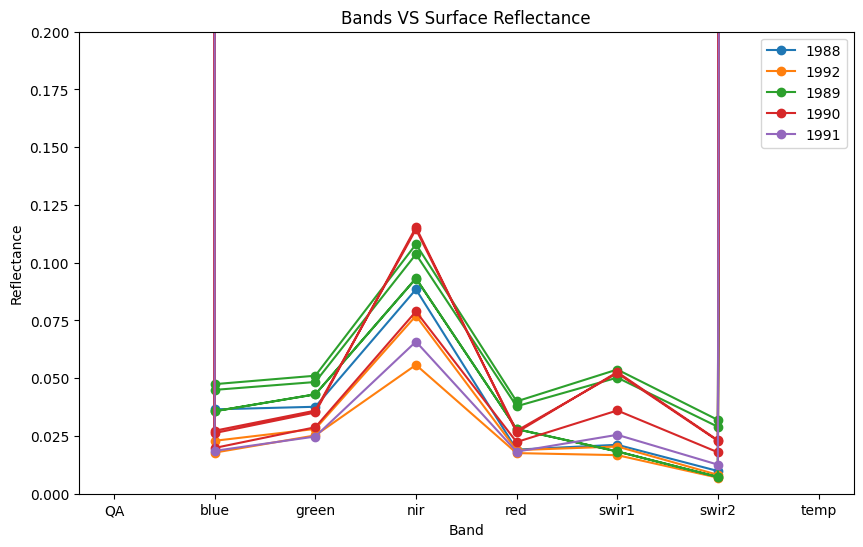

In [49]:
import matplotlib.pyplot as plt

data_by_year ={}

for index, row in df_reflectance.iterrows():
    date= row['date']
    reflectace=row['reflectance']
    
    if 1988 <=date.year <=1995 and date.month==7:
        year=date.year
        
        if year not in data_by_year:
            data_by_year[year]={'band':[], 'reflectance':[]}
            
        for band, value in reflectace.items():
            data_by_year[year]['band'].append(band)
            data_by_year[year]['reflectance'].append(value)
            
plt.figure(figsize=(10,6))

for year, data in data_by_year.items():
    plt.plot(data['band'], data['reflectance'], marker='o', label=year)
    
plt.xlabel('Band')
plt.ylabel('Reflectance')
plt.ylim(0,0.2)
plt.title('Bands VS Surface Reflectance')
plt.legend()
plt.show()